In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import make_scorer, accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool

In [36]:
import pandas as pd
df = pd.read_excel('bmc_cases.xlsb', engine='pyxlsb')

In [37]:
len(df)

116227

In [4]:
print("Non NAN data percentage")
(len(df) - df.isna().sum())/len(df)*100

Non NAN data percentage


Date                                           100.000000
S No                                            59.300335
Ward                                           100.000000
Test ID (ICMR)                                  99.988815
Patient name                                     0.000000
Age                                            100.000000
Gender                                         100.000000
Mobile Number                                    0.000000
Present Address                                  0.000000
Transferred from Ward                           10.069949
HealthPost Allocation                           81.013878
Traceable?                                      98.444423
Out of Mumbai (Yes / No)                        76.656027
Assign to other ward                             6.625827
Person / Official from other ward                7.167009
Duplicate Entry\n(Yes / No)                     70.450928
Previous Test ID (only if Duplicate is Yes)      0.316622
Patient Type (

In [5]:
data = df[['Ward','Date','Age','Gender','Symptomatic?','Traceable?','Patient Location','Patient Status (Central)','Occupation','Patient Type (Index / Contact)']]

In [46]:
data['Patient Location'].value_counts()

Building        58486
Unknown         29459
Slum / Chawl    28282
Name: Patient Location, dtype: int64

In [7]:
allowed_params = {'Symptomatic?':(['Yes','No'],'Unknown'),
                  'Traceable?':(['Yes','No'],'Unknown'),
                    'Patient Location':(['Building','Slum / Chawl'],'Unknown'),
                    'Occupation':(['At-home worker','Health worker','Other essential services','Municipal Worker','Police','RETIRED','House Wife'],'Others'),
                'Patient Type (Index / Contact)':(['Index','Contact'],'Unknown'),
                  'Gender':(['M','F'],'Others')
                 }
                    

In [8]:
def get_val(column_val,allowed):
    if column_val in allowed[0]:
        return column_val
    return allowed[1]

In [9]:
for feature in allowed_params:
    data[feature] = data.apply(lambda row : get_val(row[feature],allowed_params[feature]),axis = 1) 

<ipython-input-9-84f81ea0ce27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data.apply(lambda row : get_val(row[feature],allowed_params[feature]),axis = 1)


In [10]:
data

,Ward,Date,Age,Gender,Symptomatic?,Traceable?,Patient Location,Patient Status (Central),Occupation,Patient Type (Index / Contact)
0,A,43956,56,F,No,Yes,Slum / Chawl,Under reconciliation,Others,Contact
1,A,43959,38,F,Unknown,Yes,Unknown,Recovered,Others,Unknown
2,A,43960,31,F,Unknown,Unknown,Unknown,Recovered,Others,Unknown
3,A,43960,57,M,Unknown,Yes,Unknown,Recovered,Others,Unknown
4,A,43960,44,F,Unknown,Yes,Unknown,Recovered,Others,Unknown
...,...,...,...,...,...,...,...,...,...,...
116222,T,44032,53,M,Yes,Yes,Building,Dead,Other essential services,Index
116223,T,44034,85,M,Yes,Yes,Building,Dead,At-home worker,Index
116224,T,44037,58,M,Yes,Yes,Building,Dead,Others,Index
116225,T,44040,70,M,Yes,Yes,Building,NaN,At-home worker,Index


In [11]:
df = data[(data['Patient Status (Central)'] == 'Recovered') | (data['Patient Status (Central)'] == 'Dead')]

In [12]:
y = df['Patient Status (Central)']
X = df.drop(['Patient Status (Central)'],axis = 1)

In [13]:
print(X['Symptomatic?'].value_counts())

Yes        35645
Unknown    32031
No         29752
Name: Symptomatic?, dtype: int64


In [14]:
print(X.dtypes)
categorical_features_indices = np.where((X.dtypes == object))[0]
categorical_features_indices

Ward                              object
Date                               int64
Age                                int64
Gender                            object
Symptomatic?                      object
Traceable?                        object
Patient Location                  object
Occupation                        object
Patient Type (Index / Contact)    object
dtype: object


array([0, 3, 4, 5, 6, 7, 8])

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [48]:
from collections import Counter
y_count = Counter(y)
print(y_count)
W = {}
W[0]= len(y)/(2*y_count[0])
W[1] = len(y)/(2*y_count[1])
print(W)

Counter({1: 91487, 0: 5941})
{0: 8.19962969197105, 1: 0.532469093969635}


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [50]:
X_train_pool = Pool(X_train,label = y_train,cat_features=categorical_features_indices)
clf = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [6, 8 , 10],
          'cat_features':[categorical_features_indices],
          'loss_function': ['Logloss'],
          'l2_leaf_reg': np.linspace(1, 6, 4),
          'leaf_estimation_iterations': [10],
          'verbose':[500],
          'class_weights' : [W]
         }


In [19]:
scorer = make_scorer(roc_auc_score)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=5)

In [20]:
clf_grid.fit(
    X_train, y_train,
);

0:	learn: 0.6827249	total: 83.2ms	remaining: 41.5s
499:	learn: 0.4655853	total: 14.7s	remaining: 0us
0:	learn: 0.6831539	total: 33ms	remaining: 16.4s
499:	learn: 0.4660455	total: 16s	remaining: 0us
0:	learn: 0.6827759	total: 39.1ms	remaining: 19.5s
499:	learn: 0.4641726	total: 14.8s	remaining: 0us
0:	learn: 0.6850100	total: 22.3ms	remaining: 11.1s
499:	learn: 0.4673684	total: 14.1s	remaining: 0us
0:	learn: 0.6845878	total: 22.7ms	remaining: 11.3s
499:	learn: 0.4637981	total: 14.6s	remaining: 0us
0:	learn: 0.6827630	total: 32.3ms	remaining: 16.1s
499:	learn: 0.4681721	total: 15.1s	remaining: 0us
0:	learn: 0.6831556	total: 32.2ms	remaining: 16.1s
499:	learn: 0.4711487	total: 15.3s	remaining: 0us
0:	learn: 0.6827810	total: 26.1ms	remaining: 13s
499:	learn: 0.4672339	total: 12.6s	remaining: 0us
0:	learn: 0.6850100	total: 17ms	remaining: 8.48s
499:	learn: 0.4706298	total: 11.1s	remaining: 0us
0:	learn: 0.6846022	total: 17.7ms	remaining: 8.86s
499:	learn: 0.4677736	total: 11s	remaining: 0us


In [21]:
best_param = clf_grid.best_params_
best_param

{'cat_features': array([0, 3, 4, 5, 6, 7, 8]),
 'class_weights': {0: 8.19962969197105, 1: 0.532469093969635},
 'depth': 6,
 'iterations': 500,
 'l2_leaf_reg': 4.333333333333334,
 'leaf_estimation_iterations': 10,
 'loss_function': 'Logloss',
 'verbose': 500}

In [22]:
model = CatBoostClassifier(iterations=1000,
                           loss_function=best_param['loss_function'],
                           depth=best_param['depth'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           eval_metric='Accuracy',
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           class_weights=W,
                           logging_level='Silent'
                          );

In [23]:
model.fit(X_train_pool, eval_set=(X_val,y_val))

In [24]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)

In [25]:
W

{0: 8.19962969197105, 1: 0.532469093969635}

In [26]:
from sklearn.metrics import classification_report,confusion_matrix,plot_roc_curve
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.16      0.81      0.26      1239
           1       0.98      0.71      0.82     18247

    accuracy                           0.71     19486
   macro avg       0.57      0.76      0.54     19486
weighted avg       0.93      0.71      0.79     19486



In [27]:
confusion_matrix(y_test,predictions)

array([[ 1001,   238],
       [ 5320, 12927]])

In [28]:
df = pd.DataFrame({"Features":X.columns,"Importance":model.get_feature_importance(verbose=True)})
df.sort_values(by = 'Importance',ascending = False)

,Features,Importance
2,Age,31.668270
4,Symptomatic?,19.428337
0,Ward,13.770190
1,Date,11.245515
8,Patient Type (Index / Contact),7.637277
6,Patient Location,6.620044
3,Gender,3.969749
7,Occupation,3.702366
5,Traceable?,1.958252


In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

In [30]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})

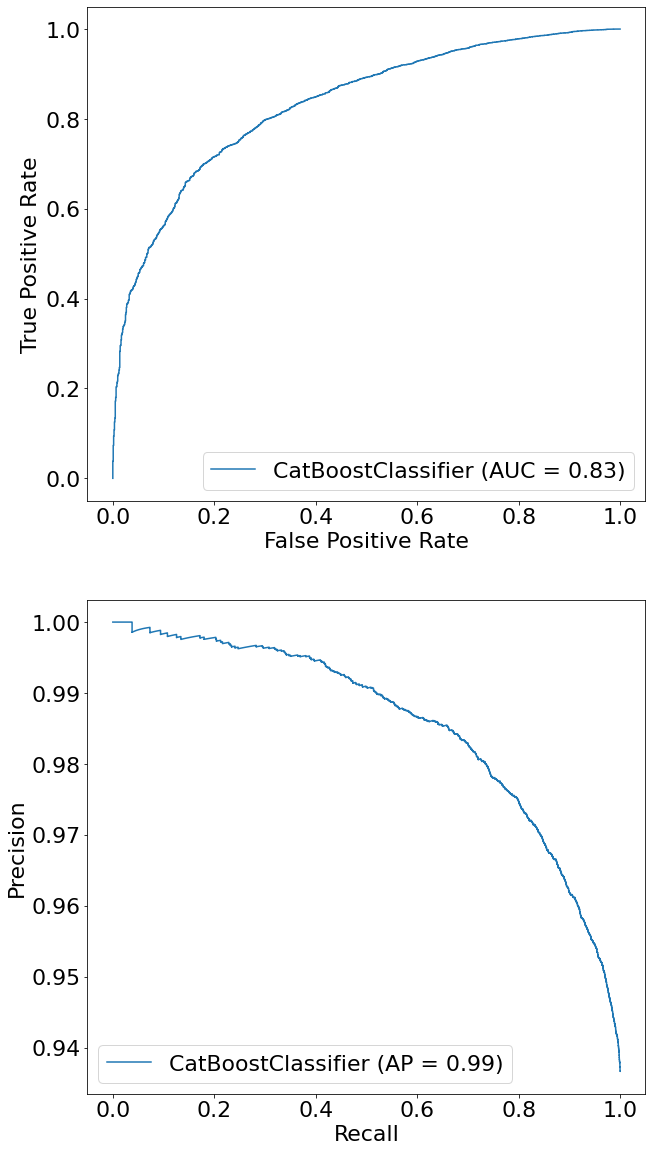

In [31]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,1,figsize=[10,20])
plot_roc_curve(model,X_test,y_test,ax =ax.flat[0])
plot_precision_recall_curve(model,X_test,y_test,ax =ax.flat[1])

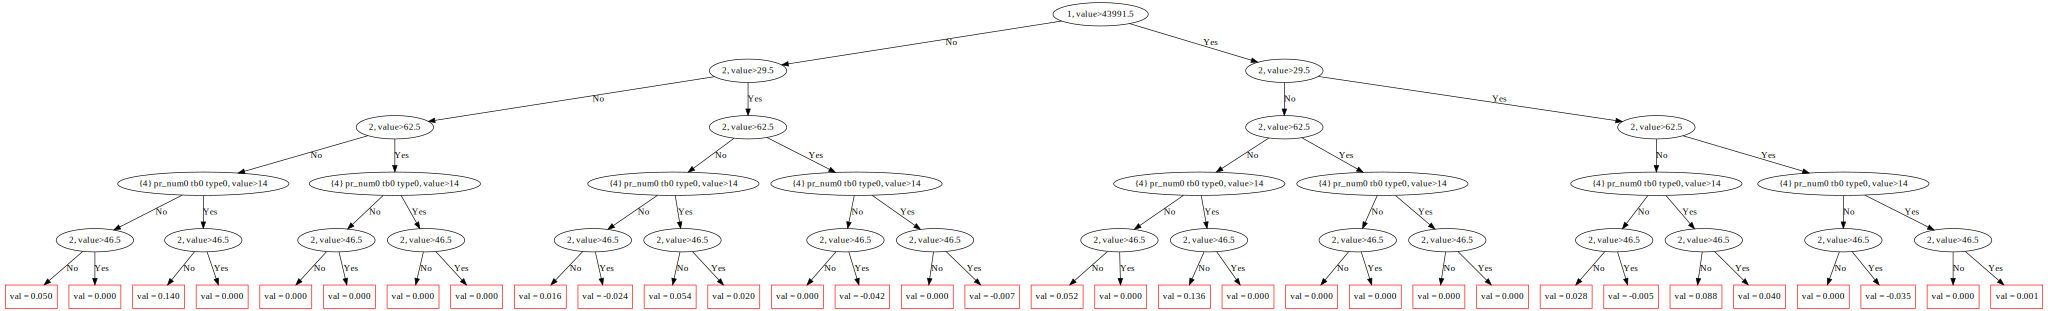

In [32]:
model.plot_tree(0)

In [61]:
1 - np.mean(y_test)

0.06358411166991684

In [63]:
X_test['label'] = le.inverse_transform(y_test)

<ipython-input-63-527e39416c10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['label'] = le.inverse_transform(y_test)


In [64]:
tree_dict = {}
tree_data = X_test[['Age','Symptomatic?','label']]
age_bins = [0,29.5,46.5,62.5,150]
bins = [(age_bins[i],age_bins[i+1]) for i in range(len(age_bins)-1)]
sym_classes = list(tree_data['Symptomatic?'].value_counts().keys())
test_g = tree_data.groupby(pd.cut(tree_data['Age'],bins =age_bins ))
print(bins)
print(sym_classes)
for age_bin,df_group in test_g:
    tree_dict[(age_bin.left,age_bin.right)] = {}
    test_g2 = df_group.groupby(df_group["Symptomatic?"])
    for sym_bin,df_group2 in test_g2:
        tree_dict[(age_bin.left,age_bin.right)][sym_bin] = df_group2['label'].value_counts()
for b in bins:
    print('X'*20)
    for s in sym_classes:
        print(b,s)
        print(tree_dict[b][s])
        print((100*tree_dict[b][s][0])/(tree_dict[b][s][0]+tree_dict[b][s][1]))
        print('-'*10)

[(0, 29.5), (29.5, 46.5), (46.5, 62.5), (62.5, 150)]
['Yes', 'Unknown', 'No']
XXXXXXXXXXXXXXXXXXXX
(0, 29.5) Yes
1    1027
0      15
Name: label, dtype: int64
1.4395393474088292
----------
(0, 29.5) Unknown
1    1317
0      15
Name: label, dtype: int64
1.1261261261261262
----------
(0, 29.5) No
1    1479
0       2
Name: label, dtype: int64
0.1350438892640108
----------
XXXXXXXXXXXXXXXXXXXX
(29.5, 46.5) Yes
1    2022
0      67
Name: label, dtype: int64
3.2072762087123023
----------
(29.5, 46.5) Unknown
1    1992
0      87
Name: label, dtype: int64
4.184704184704184
----------
(29.5, 46.5) No
1    1999
0      13
Name: label, dtype: int64
0.6461232604373758
----------
XXXXXXXXXXXXXXXXXXXX
(46.5, 62.5) Yes
1    2201
0     244
Name: label, dtype: int64
9.979550102249489
----------
(46.5, 62.5) Unknown
1    1719
0     205
Name: label, dtype: int64
10.654885654885655
----------
(46.5, 62.5) No
1    1671
0      26
Name: label, dtype: int64
1.5321154979375369
----------
XXXXXXXXXXXXXXXXXXXX
(62